In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
#njobs = 4

### Get Data

In [8]:
train = pd.read_csv("/mnt/beegfs/input/train.csv")
print("train : " + str(train.shape))

train : (1460, 81)


### Check for duplicates

In [9]:
idsUnique = len(set(train.Id))
idsTotal = train.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

# Drop Id column
train.drop("Id", axis = 1, inplace = True)

There are 0 duplicate IDs for 1460 total entries


### Preprocessing

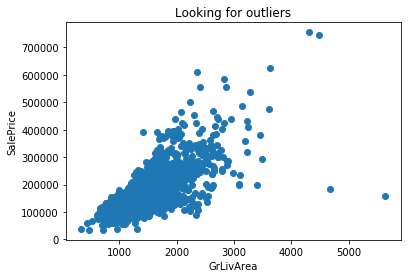

In [10]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.scatter(train.GrLivArea, train.SalePrice)
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

train = train[train.GrLivArea < 4000]

### Log Transformation

In [11]:
train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice

### Handling missing values

In [12]:
# Alley : data description says NA means "no alley access"
train.loc[:, "Alley"] = train.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
train.loc[:, "BedroomAbvGr"] = train.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
train.loc[:, "BsmtQual"] = train.loc[:, "BsmtQual"].fillna("No")
train.loc[:, "BsmtCond"] = train.loc[:, "BsmtCond"].fillna("No")
train.loc[:, "BsmtExposure"] = train.loc[:, "BsmtExposure"].fillna("No")
train.loc[:, "BsmtFinType1"] = train.loc[:, "BsmtFinType1"].fillna("No")
train.loc[:, "BsmtFinType2"] = train.loc[:, "BsmtFinType2"].fillna("No")
train.loc[:, "BsmtFullBath"] = train.loc[:, "BsmtFullBath"].fillna(0)
train.loc[:, "BsmtHalfBath"] = train.loc[:, "BsmtHalfBath"].fillna(0)
train.loc[:, "BsmtUnfSF"] = train.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
train.loc[:, "CentralAir"] = train.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
train.loc[:, "Condition1"] = train.loc[:, "Condition1"].fillna("Norm")
train.loc[:, "Condition2"] = train.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
train.loc[:, "EnclosedPorch"] = train.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
train.loc[:, "ExterCond"] = train.loc[:, "ExterCond"].fillna("TA")
train.loc[:, "ExterQual"] = train.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
train.loc[:, "Fence"] = train.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
train.loc[:, "FireplaceQu"] = train.loc[:, "FireplaceQu"].fillna("No")
train.loc[:, "Fireplaces"] = train.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
train.loc[:, "Functional"] = train.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
train.loc[:, "GarageType"] = train.loc[:, "GarageType"].fillna("No")
train.loc[:, "GarageFinish"] = train.loc[:, "GarageFinish"].fillna("No")
train.loc[:, "GarageQual"] = train.loc[:, "GarageQual"].fillna("No")
train.loc[:, "GarageCond"] = train.loc[:, "GarageCond"].fillna("No")
train.loc[:, "GarageArea"] = train.loc[:, "GarageArea"].fillna(0)
train.loc[:, "GarageCars"] = train.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
train.loc[:, "HalfBath"] = train.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
train.loc[:, "HeatingQC"] = train.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
train.loc[:, "KitchenAbvGr"] = train.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
train.loc[:, "KitchenQual"] = train.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
train.loc[:, "LotShape"] = train.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
train.loc[:, "MasVnrType"] = train.loc[:, "MasVnrType"].fillna("None")
train.loc[:, "MasVnrArea"] = train.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
train.loc[:, "MiscFeature"] = train.loc[:, "MiscFeature"].fillna("No")
train.loc[:, "MiscVal"] = train.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
train.loc[:, "OpenPorchSF"] = train.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
train.loc[:, "PavedDrive"] = train.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
train.loc[:, "PoolQC"] = train.loc[:, "PoolQC"].fillna("No")
train.loc[:, "PoolArea"] = train.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
train.loc[:, "SaleCondition"] = train.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
train.loc[:, "ScreenPorch"] = train.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
train.loc[:, "TotRmsAbvGrd"] = train.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
train.loc[:, "Utilities"] = train.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
train.loc[:, "WoodDeckSF"] = train.loc[:, "WoodDeckSF"].fillna(0)

In [13]:
train = train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [14]:
train = train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [15]:
# Create new features
# 1* Simplifications of existing features
train["SimplOverallQual"] = train.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplOverallCond"] = train.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplPoolQC"] = train.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
train["SimplGarageCond"] = train.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplGarageQual"] = train.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFunctional"] = train.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
train["SimplKitchenQual"] = train.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplHeatingQC"] = train.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplBsmtFinType1"] = train.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtFinType2"] = train.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtCond"] = train.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplBsmtQual"] = train.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplExterCond"] = train.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplExterQual"] = train.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })

# 2* Combinations of existing features
# Overall quality of the house
train["OverallGrade"] = train["OverallQual"] * train["OverallCond"]
# Overall quality of the garage
train["GarageGrade"] = train["GarageQual"] * train["GarageCond"]
# Overall quality of the exterior
train["ExterGrade"] = train["ExterQual"] * train["ExterCond"]
# Overall kitchen score
train["KitchenScore"] = train["KitchenAbvGr"] * train["KitchenQual"]
# Overall fireplace score
train["FireplaceScore"] = train["Fireplaces"] * train["FireplaceQu"]
# Overall garage score
train["GarageScore"] = train["GarageArea"] * train["GarageQual"]
# Overall pool score
train["PoolScore"] = train["PoolArea"] * train["PoolQC"]
# Simplified overall quality of the house
train["SimplOverallGrade"] = train["SimplOverallQual"] * train["SimplOverallCond"]
# Simplified overall quality of the exterior
train["SimplExterGrade"] = train["SimplExterQual"] * train["SimplExterCond"]
# Simplified overall pool score
train["SimplPoolScore"] = train["PoolArea"] * train["SimplPoolQC"]
# Simplified overall garage score
train["SimplGarageScore"] = train["GarageArea"] * train["SimplGarageQual"]
# Simplified overall fireplace score
train["SimplFireplaceScore"] = train["Fireplaces"] * train["SimplFireplaceQu"]
# Simplified overall kitchen score
train["SimplKitchenScore"] = train["KitchenAbvGr"] * train["SimplKitchenQual"]
# Total number of bathrooms
train["TotalBath"] = train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]) + \
train["FullBath"] + (0.5 * train["HalfBath"])
# Total SF for house (incl. basement)
train["AllSF"] = train["GrLivArea"] + train["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
train["AllFlrsSF"] = train["1stFlrSF"] + train["2ndFlrSF"]
# Total SF for porch
train["AllPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + \
train["3SsnPorch"] + train["ScreenPorch"]
# Has masonry veneer or not
train["HasMasVnr"] = train.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
train["BoughtOffPlan"] = train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

In [16]:
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice            1.000
OverallQual          0.819
AllSF                0.817
AllFlrsSF            0.729
GrLivArea            0.719
SimplOverallQual     0.708
ExterQual            0.681
GarageCars           0.680
TotalBath            0.673
KitchenQual          0.667
GarageScore          0.657
GarageArea           0.655
TotalBsmtSF          0.642
SimplExterQual       0.636
SimplGarageScore     0.631
BsmtQual             0.615
1stFlrSF             0.614
SimplKitchenQual     0.610
OverallGrade         0.604
SimplBsmtQual        0.594
FullBath             0.591
YearBuilt            0.589
ExterGrade           0.587
YearRemodAdd         0.569
FireplaceQu          0.547
GarageYrBlt          0.544
TotRmsAbvGrd         0.533
SimplOverallGrade    0.527
SimplKitchenScore    0.523
FireplaceScore       0.518
                     ...  
SimplBsmtCond        0.204
BedroomAbvGr         0.204
AllPorchSF           0.199
LotFrontage          0.174
SimplFu

In [17]:
# Create new features
# 3* Polynomials on the top 10 existing features
train["OverallQual-s2"] = train["OverallQual"] ** 2
train["OverallQual-s3"] = train["OverallQual"] ** 3
train["OverallQual-Sq"] = np.sqrt(train["OverallQual"])
train["AllSF-2"] = train["AllSF"] ** 2
train["AllSF-3"] = train["AllSF"] ** 3
train["AllSF-Sq"] = np.sqrt(train["AllSF"])
train["AllFlrsSF-2"] = train["AllFlrsSF"] ** 2
train["AllFlrsSF-3"] = train["AllFlrsSF"] ** 3
train["AllFlrsSF-Sq"] = np.sqrt(train["AllFlrsSF"])
train["GrLivArea-2"] = train["GrLivArea"] ** 2
train["GrLivArea-3"] = train["GrLivArea"] ** 3
train["GrLivArea-Sq"] = np.sqrt(train["GrLivArea"])
train["SimplOverallQual-s2"] = train["SimplOverallQual"] ** 2
train["SimplOverallQual-s3"] = train["SimplOverallQual"] ** 3
train["SimplOverallQual-Sq"] = np.sqrt(train["SimplOverallQual"])
train["ExterQual-2"] = train["ExterQual"] ** 2
train["ExterQual-3"] = train["ExterQual"] ** 3
train["ExterQual-Sq"] = np.sqrt(train["ExterQual"])
train["GarageCars-2"] = train["GarageCars"] ** 2
train["GarageCars-3"] = train["GarageCars"] ** 3
train["GarageCars-Sq"] = np.sqrt(train["GarageCars"])
train["TotalBath-2"] = train["TotalBath"] ** 2
train["TotalBath-3"] = train["TotalBath"] ** 3
train["TotalBath-Sq"] = np.sqrt(train["TotalBath"])
train["KitchenQual-2"] = train["KitchenQual"] ** 2
train["KitchenQual-3"] = train["KitchenQual"] ** 3
train["KitchenQual-Sq"] = np.sqrt(train["KitchenQual"])
train["GarageScore-2"] = train["GarageScore"] ** 2
train["GarageScore-3"] = train["GarageScore"] ** 3
train["GarageScore-Sq"] = np.sqrt(train["GarageScore"])

### Differentiate numerical features (minus the target) and categorical features

In [18]:
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features : 117
Categorical features : 26


### Handle remaining missing values for numerical features by using median as replacement

In [19]:
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 81
Remaining NAs for numerical features in train : 0


### Log transform of the skewed numerical features to lessen impact of outlinears

In [20]:
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

86 skewed numerical features to log transform


### Create dummy features for categorical values

In [21]:
print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
train_cat = pd.get_dummies(train_cat)
print("Remaining NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))

NAs for categorical features in train : 1
Remaining NAs for categorical features in train : 0


### Modeling

In [22]:
# Join categorical and numerical features
train = pd.concat([train_num, train_cat], axis = 1)
print("New number of features : " + str(train.shape[1]))

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

New number of features : 319
X_train : (1019, 319)
X_test : (437, 319)
y_train : (1019,)
y_test : (437,)


### Standardize numerical features

In [23]:
stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

/root/venv_3/lib/python3.4/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Define error measure for official scoring: RMSE

In [24]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

### 1*Linear Regression without regularization

RMSE on Training set : 0.388287110213
RMSE on Test set : 0.435768851917


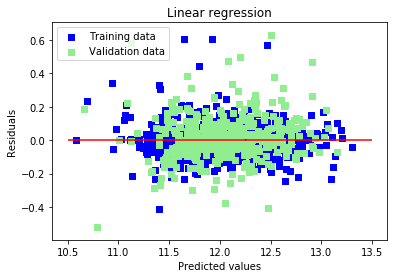

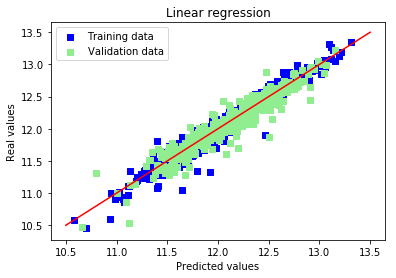

In [27]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

### 2*Linear Regression with Ridge regularization (L2 penalty)

Best alpha : 30.0
Try again for more precision with alphas centered around 30.0
Best alpha : 24.0
Ridge RMSE on Training set : 0.115405723285
Ridge RMSE on Test set : 0.116427213778


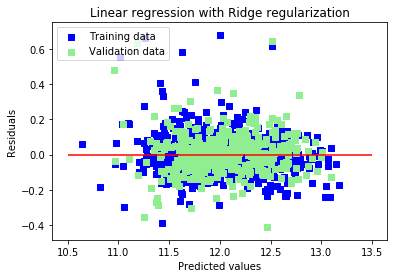

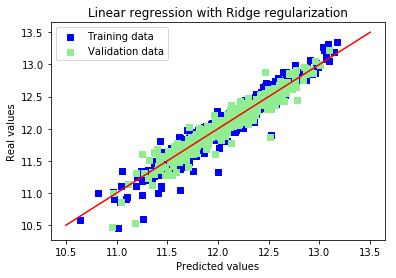

Ridge picked 316 features and eliminated the other 3 features


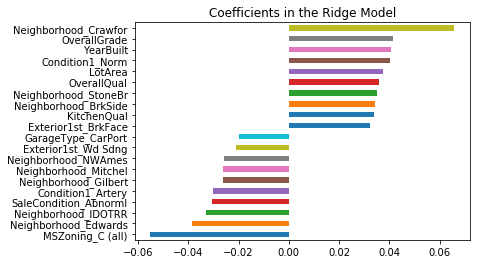

In [33]:
# 2* Ridge
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

### 3* Linear Regression with Lasso regularization (L1 penalty)

Best alpha : 0.0006
Try again for more precision with alphas centered around 0.0006
Best alpha : 0.0006
Lasso RMSE on Training set : 0.114111508375
Lasso RMSE on Test set : 0.115832132218


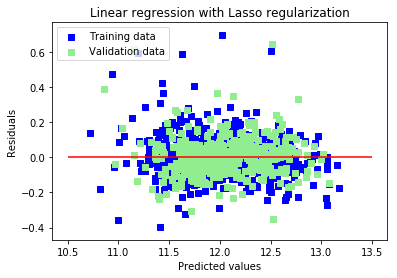

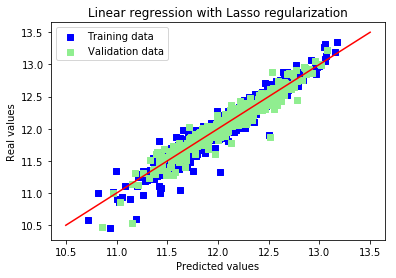

Lasso picked 111 features and eliminated the other 208 features


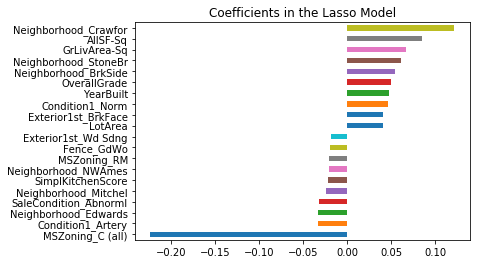

In [30]:
# 3* Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

### 4* Linear Regression with ElasticNet regularization (L1 and L2 penalty)

/root/venv_3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Best l1_ratio : 1.0
Best alpha : 0.0006
Try again for more precision with l1_ratio centered around 1.0
Best l1_ratio : 1.0
Best alpha : 0.0006
Now try again for more precision on alpha, with l1_ratio fixed at 1.0 and alpha centered around 0.0006
Best l1_ratio : 1.0
Best alpha : 0.0006
ElasticNet RMSE on Training set : 0.114111508375
ElasticNet RMSE on Test set : 0.115832132218


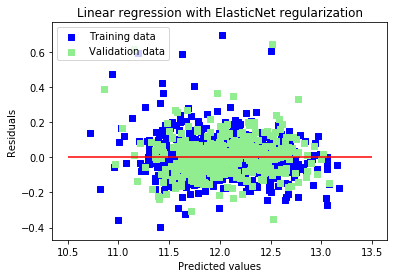

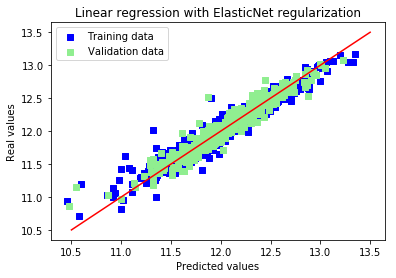

ElasticNet picked 111 features and eliminated the other 208 features


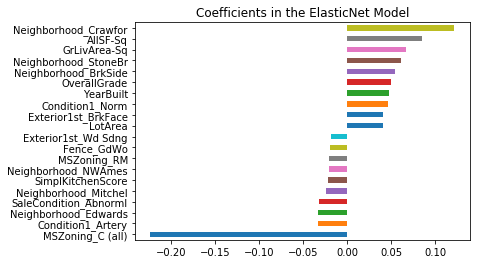

In [32]:
# 4* ElasticNet
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()